# Create Labels from OpenStreetMap Data
This notebook demonstrates a process of using buteo and osmnx to create labels from open street map data.

In [ ]:
# Download OSMNX and Buteo
!pip install buteo --upgrade
!pip install osmnx --upgrade

# An example raster of the Sentinel 2 RED band in 60m resolution over Baalbeck in Lebanon.
!wget -nc https://github.com/casperfibaek/buteo/raw/master/geometry_and_rasters/s2_b04_baalbeck.tif

In [ ]:
import buteo as beo
import osmnx as ox
import geopandas as gpd

In [ ]:
# Setup the input and output paths
PATH_REFERENCE_RASTER = "/content/s2_b04_baalbeck.tif"

OUT_PATH_ROADS = "/content/roads.gpkg"
OUT_PATH_ROADS_LABELS = "/content/label_roads.tif"

In [ ]:
# Get the bounds of the reference raster
metadata = beo.raster_to_metadata(PATH_REFERENCE_RASTER)
x_min, x_max, y_min, y_max = metadata["bbox_latlng"] # OGR-format

# Download road network using OSMNX (Can be slow, depending on connection)
road_network = ox.geometries.geometries_from_bbox(y_max, y_min, x_max, x_min, { "highway": True } ) # NSEW-format

In [ ]:
# Prepare the road network for "rasterfication".
filtered = road_network[road_network["geometry"].type.values == "LineString"] # Remove roundabouts, polygons, etc..
filtered = filtered[["highway", "geometry"]] # Remove redundant columns

# Parse the projection from a vector, raster, osr projection, EPSG, proj4, ..., can be paths.
target_projection = beo.parse_projection(PATH_REFERENCE_RASTER, return_wkt=True)
filtered = filtered.to_crs(target_projection) # Set to the same projection as the reference_raster or use reproject.

# OBS: It is important to that the target projection is not lat/lng, but a projected system. If not, the buffer
# distance should be given in degrees

# https://wiki.openstreetmap.org/wiki/Key:highway
filtered["buffer_dist"] = 3.0 # Default buffer
filtered.loc[filtered['highway'] == "residential", "buffer_dist"] = 2.0 # Placeholder values
filtered.loc[filtered['highway'] == "unclassified", "buffer_dist"] = 1.5
filtered.loc[filtered['highway'] == "tertiary", "buffer_dist"] = 2.0
filtered.loc[filtered['highway'] == "primary", "buffer_dist"] = 4.0

filtered.to_file(OUT_PATH_ROADS, driver='GPKG', encoding='latin1')

In [ ]:
# Buffer by attribute. If no outpath is specified, the vector is created in memory and a path is returned.
in_memory_vector = beo.buffer_vector(OUT_PATH_ROADS, "buffer_dist")

# Rasterize at high resolution before resampling by average to create fuzzy labels. 
in_memory_raster = beo.rasterize_vector(
    in_memory_vector,
    pixel_size=1.0, # 1m rasterization. (Change depending on available ressources.)
    extent=PATH_REFERENCE_RASTER,
)

# Resample to reference resolution (60m in this case)
beo.resample_raster(
    in_memory_raster,
    target_size=PATH_REFERENCE_RASTER, # <-- Size can be read from floats, ints and raster files
    out_path=OUT_PATH_ROADS_LABELS, # <-- out_path is specified, so no memory raster is created.
    resample_alg="average",
    dtype="float32",
)

# OBS: Here, the rasters are aligned, but if they werent:
# beo.align_rasters and beo.rasters_are_aligned could 

# Clean memory. Not important here, but if you do it in a big loop, you'll run out of RAM eventually.
beo.utils.gdal_utils.delete_if_in_memory(in_memory_raster)
beo.utils.gdal_utils.delete_if_in_memory(in_memory_vector)

## Visualize the results.

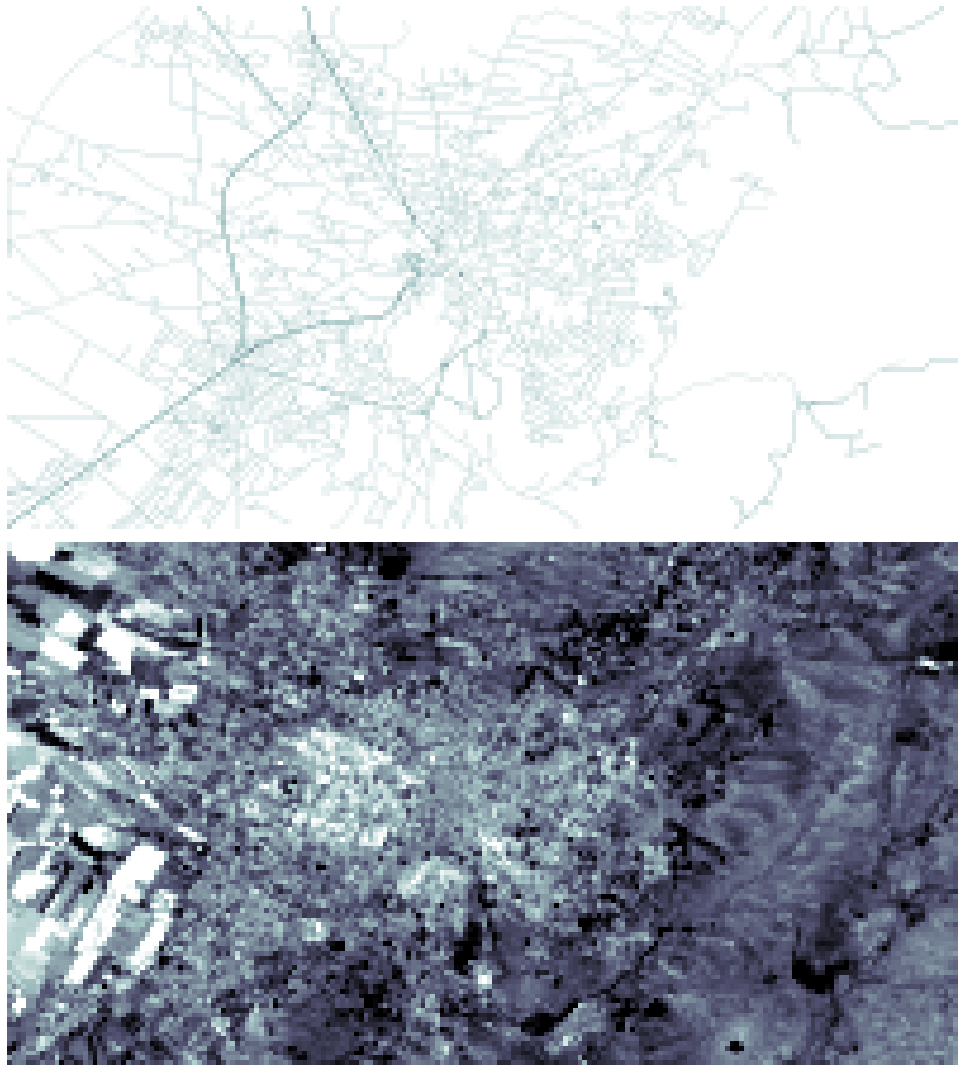

In [ ]:
# Visualise road network, OBS. white border is from pyplot.
from matplotlib import pyplot as plt
import numpy as np

arr_roads = beo.raster.core_raster.raster_to_array(OUT_PATH_ROADS_LABELS)[:, :, 0] # plt reads 2D
arr_band4 = beo.raster.core_raster.raster_to_array(PATH_REFERENCE_RASTER)[:, :, 0] # plt reads 2D

ncols = 1
nrows = 2
size = 24
aspect_ratio = arr_roads.shape[0] / arr_roads.shape[1]
figsize = (size * ncols * aspect_ratio, size * nrows)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
roads, band4 = axes

for ax in axes:
    ax.axis('off')

max_road_value = 0.6 # <-- Max potential value is 1.0, here 0.6 is used to show more contrast.
roads.imshow(arr_roads, vmin=max_road_value, vmax=0.6, interpolation="nearest", cmap="bone_r")
band4.imshow(arr_band4, vmin=np.quantile(arr_band4, 0.02), vmax=np.quantile(arr_band4, 0.98), interpolation="nearest", cmap="bone_r")

plt.subplots_adjust(
    top=1.0,
    bottom=0.69,
    right=1.0,
    left=0.0,
    hspace=0.0,
    wspace=0.0,
)
plt.show()